In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [29]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX','SPY']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [30]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [31]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [32]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [60]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [61]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [62]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [63]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [64]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [65]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Get value of portfolio at the beginning and end of year

In [66]:
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

# Portfolio value at start of 2021
port_val_start = get_port_val_by_date('2021-01-04', port_shares, port_list)
print("Portfolio Value at Start of 2021 : $%2.2f" % (port_val_start))

# Portfolio value at end of 2021
port_val_end = get_port_val_by_date('2021-12-31', port_shares, port_list)
print("Portfolio Value at End of 2021 : $%2.2f" % (port_val_end))

Portfolio Value at Start of 2021 : $121.42
Portfolio Value at End of 2021 : $181.85


## ROI

In [67]:
# Rate of return for portfolio
roi_port = (port_val_end - port_val_start) / port_val_end
print("Portfolio ROI at End of 2021 : %2.2f %%" % (roi_port * 100))

# S&P ROI
sp_df = get_df_from_csv('adj_close','SPY')
sp_val_start = get_prices_on_date(sp_df, '2021-01-04')
sp_val_end = get_prices_on_date(sp_df, '2021-12-31')
sp_roi = (sp_val_end - sp_val_start) / sp_val_end
print("S&P ROI at End of 2021 : %2.2f %%" % (sp_roi * 100))

Portfolio ROI at End of 2021 : 33.23 %
S&P ROI at End of 2021 : 23.37 %


## Find Daily Return for Whole Portfolio

In [68]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [69]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,0.7776,34.071130,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,0.7788,34.166381,0.002796
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,0.7452,34.106141,-0.001763
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,0.7688,34.345449,0.007017
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227233,0.7524,34.208485,-0.003988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,16.310584,4.366989,1.594381,0.466565,0.517141,3.057787,23.575611,0.5008,183.786467,0.021295
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,15.452614,4.368961,1.575072,0.465449,0.510216,3.055801,23.659862,0.4980,181.640680,-0.011675
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,15.704098,4.327990,1.543838,0.463032,0.519585,3.080197,23.673393,0.5176,181.846645,0.001134


## Find Portfolio Beta

In [70]:
def find_port_beta(port_df, sdate, edate):
    # Will hold data for S&P and my portfolio
    mult_df = pd.DataFrame()
    
    # Mask defining the dates worth of data that we want
    port_mask = (port_df.index >= sdate) & (port_df.index <= edate)
    
    # Get S&P Dataframe
    sp_df = get_df_from_csv('adj_close','SPY')
    
    sp_mask = (sp_df.index >= sdate) & (sp_df.index <= edate)
    
    # Add S&P daily return to dataframe
    mult_df['SPY'] = sp_df.loc[sp_mask]['daily_return']
    
    # Add the portfolio daily return data
    mult_df['Portfolio'] = port_df.loc[port_mask]['daily_return']
    
    # Provides the covariance between the securities
    cov = mult_df.cov() * 252
    
    # Get the covariance of the stocks and the market
    cov_vs_market = cov.iloc[0,1]
    
    # Get annualized variance of the S&P
    sp_var = mult_df['SPY'].var() * 252
    
    # Beta is normally calculated over a 5 year period which is why you may see a difference
    beta = cov_vs_market / sp_var
    return beta

## Calculating alpha

In [71]:
port_beta = find_port_beta(tot_port_df, '2021-01-04', '2021-12-31')
port_beta

1.2593568821756884

In [72]:
risk_free_rate = 0.01
port_alpha = roi_port - risk_free_rate - (port_beta * (sp_roi - risk_free_rate))
print("Portfolio Alpha : %2.2f %%" % (port_alpha * 100))

Portfolio Alpha : 4.05 %


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040668,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.459679,0.350710,0.186926,0.164165,0.895578,6.416034,0.7776,34.080989,NaN
2017-01-04,3.572773,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.481428,0.360827,0.191502,0.154796,0.910045,6.425155,0.7788,34.175405,0.002770
2017-01-05,3.560093,0.231029,2.862818,5.076722,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.469880,0.366447,0.191273,0.146242,0.902386,6.340037,0.7452,34.114569,-0.001780
2017-01-06,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.455445,0.374316,0.188756,0.146038,0.885082,6.293830,0.7688,34.354126,0.007022
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,1.969254,1.401746,0.375440,0.191273,0.144612,0.883096,6.261608,0.7524,34.215206,-0.004044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,16.310584,4.405769,1.602869,0.476256,0.517141,3.057787,23.627243,0.5008,183.895057,0.021294
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,15.452614,4.407759,1.583458,0.475117,0.510216,3.055801,23.711680,0.4980,181.749349,-0.011668
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,15.704098,4.366424,1.552057,0.472649,0.519585,3.080197,23.725239,0.5176,181.954761,0.001130


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040668,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.459679,0.350710,0.186926,0.164165,0.895578,6.416034,0.7776,34.080989,NaN
2017-01-04,3.572773,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.481428,0.360827,0.191502,0.154796,0.910045,6.425155,0.7788,34.175405,0.002770
2017-01-05,3.560093,0.231029,2.862818,5.076722,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.469880,0.366447,0.191273,0.146242,0.902386,6.340037,0.7452,34.114569,-0.001780
2017-01-06,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.455445,0.374316,0.188756,0.146038,0.885082,6.293830,0.7688,34.354126,0.007022
2017-01-07,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.455445,0.374316,0.188756,0.146038,0.885082,6.293830,0.7688,34.354126,0.007022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,16.310584,4.405769,1.602869,0.476256,0.517141,3.057787,23.627243,0.5008,183.895057,0.021294
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,15.452614,4.407759,1.583458,0.475117,0.510216,3.055801,23.711680,0.4980,181.749349,-0.011668
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,15.704098,4.366424,1.552057,0.472649,0.519585,3.080197,23.725239,0.5176,181.954761,0.001130


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,34.080989
2017-01-04,34.175405
2017-01-05,34.114569
2017-01-06,34.354126
2017-01-07,34.354126
...,...
2021-12-27,183.895057
2021-12-28,181.749349
2021-12-29,181.954761


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


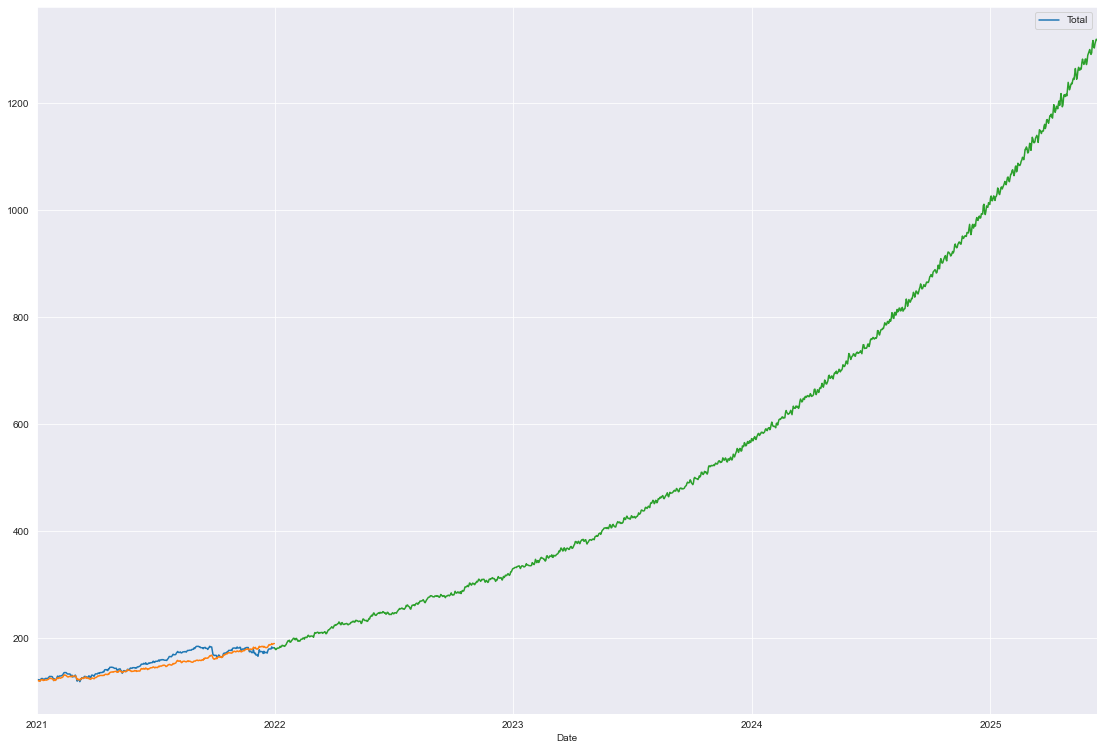

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31     182.335954
2022-01-01     180.685991
2022-01-02     178.851997
2022-01-03     179.169890
2022-01-04     181.108459
                 ...     
2025-06-09    1302.917694
2025-06-10    1310.592671
2025-06-11    1314.937485
2025-06-12    1319.269921
2025-06-13    1318.445834
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,182.335954
2022-01-01,180.685991
2022-01-02,178.851997
2022-01-03,179.169890
2022-01-04,181.108459
...,...
2025-06-09,1302.917694
2025-06-10,1310.592671
2025-06-11,1314.937485
2025-06-12,1319.269921


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.009049
2022-01-02,-0.019107
2022-01-03,-0.017364
2022-01-04,-0.006732
...,...
2025-06-09,6.145698
2025-06-10,6.187791
2025-06-11,6.211619
2025-06-12,6.235380


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  48.538145
